<a href="https://colab.research.google.com/github/ksdkamesh99/LowLightEnhancer/blob/master/model_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
cd /content/drive/My Drive/LowLightEnhancement

/content/drive/My Drive/LowLightEnhancement


In [16]:
import tensorflow as tf
import keras
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


In [17]:
img_high=np.load("image_high.npy")

In [18]:
img_low=np.load("image_low.npy")

In [19]:
img_low=img_low/255
img_high=img_high/255

In [20]:
img_high.shape

(1485, 96, 96, 3)

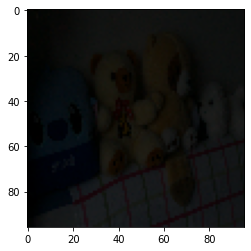

In [21]:
plt.imshow(img_low[0])

## Illumination Mask Network

In [ ]:
input_layer_1=keras.layers.Input(shape=(96,96,3))

In [ ]:
top=keras.layers.Conv2D(64,kernel_size=(3,3),input_shape=(96,96,3),padding='same')(input_layer_1)
top=keras.layers.Conv2D(64,kernel_size=(3,3),padding='same')(top)

In [ ]:

top.get_shape

<bound method Tensor.get_shape of <tf.Tensor 'conv2d_776/BiasAdd:0' shape=(None, 96, 96, 64) dtype=float32>>

In [ ]:

bottom_inp=input_layer_1
bottom_resize=tf.keras.layers.Lambda(
    lambda img: tf.image.resize(img,(60,60))
)(bottom_inp)

In [ ]:
bottom=keras.layers.Conv2D(64,kernel_size=(3,3),input_shape=(60,60,3),padding='same')(bottom_resize)
bottom=keras.layers.Conv2D(64,kernel_size=(3,3),padding='same')(bottom)
bottom=keras.layers.Conv2D(64,kernel_size=(3,3),padding='same')(bottom)


In [ ]:
bottom.get_shape()

TensorShape([None, 60, 60, 64])

In [ ]:
bottom=keras.layers.experimental.preprocessing.Resizing(96,96)(bottom)

In [ ]:
bottom.get_shape()

TensorShape([None, 96, 96, 64])

In [ ]:
top.get_shape()

TensorShape([None, 96, 96, 64])

In [ ]:
merged=keras.layers.concatenate([top,bottom])

In [ ]:
merged

<tf.Tensor 'concatenate_200/concat:0' shape=(None, 96, 96, 128) dtype=float32>

In [ ]:
merged=keras.layers.Conv2D(32,kernel_size=(7,7),padding='same')(merged)
merged=keras.layers.Conv2D(8,kernel_size=(1,1),padding='same')(merged)
merged=keras.layers.Conv2D(1,kernel_size=(5,5),activation='sigmoid',padding='same')(merged)

In [ ]:
merged.get_shape()

TensorShape([None, 96, 96, 1])

In [ ]:
model_illumination_mask=keras.models.Model(inputs=input_layer_1,outputs=merged)

In [ ]:
model_illumination_mask.summary()

Model: "functional_101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
lambda_300 (Lambda)             (None, 60, 60, 3)    0           input_26[0][0]                   
__________________________________________________________________________________________________
conv2d_777 (Conv2D)             (None, 60, 60, 64)   1792        lambda_300[0][0]                 
__________________________________________________________________________________________________
conv2d_778 (Conv2D)             (None, 60, 60, 64)   36928       conv2d_777[0][0]                 
_____________________________________________________________________________________

# Illumination Map 

In [ ]:
merged.get_shape

<bound method Tensor.get_shape of <tf.Tensor 'conv2d_782/Sigmoid:0' shape=(None, 96, 96, 1) dtype=float32>>

In [ ]:
merged=keras.layers.Concatenate()([input_layer_1,merged])

In [ ]:
merged

<tf.Tensor 'concatenate_201/concat:0' shape=(None, 96, 96, 4) dtype=float32>

In [ ]:
def ieb(input_feature):
  ieb1=keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu',padding='same')(input_feature)
  ieb1=keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu',padding='same')(ieb1)
  max_pool=keras.layers.GlobalMaxPooling2D()(ieb1)
  avg_pool=keras.layers.GlobalAveragePooling2D()(ieb1)
  dense1=keras.layers.Dense(8,activation='relu')
  dense2=keras.layers.Dense(32,activation='sigmoid')
  max_pool=dense1(max_pool)
  max_pool=dense2(max_pool)
  avg_pool=dense1(avg_pool)
  avg_pool=dense2(avg_pool)
  '''max_pool=keras.layers.Lambda(
    lambda image: keras.backend.expand_dims(keras.backend.expand_dims(image,axis=1),axis=1))(max_pool)
  avg_pool=keras.layers.Lambda(
    lambda image: keras.backend.expand_dims(keras.backend.expand_dims(image,axis=1),axis=1))(avg_pool)'''
  channel=keras.layers.Add()([max_pool,avg_pool])
  ieb1=keras.layers.Multiply()([ieb1,channel])
  max_pool_s=tf.keras.layers.Lambda(
    lambda x: keras.backend.max(x,axis=3,keepdims=True))(ieb1)
  avg_pool_s=keras.layers.Lambda(
    lambda x: keras.backend.mean(x,axis=3,keepdims=True))(ieb1)
  concat_slayers=keras.layers.Concatenate(axis=3)([avg_pool_s,max_pool_s])
  spacial=keras.layers.Conv2D(1,7,activation='sigmoid',padding='same')(concat_slayers)
  #spacial=keras.layers.experimental.preprocessing.Resizing(92,92)(spacial)
  ieb1=keras.layers.Multiply()([ieb1,spacial])
  ieb1=keras.layers.BatchNormalization()(ieb1)
  ieb1=keras.layers.Activation('relu')(ieb1)
  #ieb1=keras.layers.experimental.preprocessing.Resizing(96,96)(ieb1)
  return ieb1


  



In [ ]:
ieb_1=ieb(merged)

In [ ]:
ieb_2=ieb(ieb_1)

In [ ]:


ieb_3=ieb(ieb_2)

In [ ]:
ieb_4=ieb(ieb_3)

In [ ]:
ieb_5=ieb(ieb_4)

In [ ]:
added_ieb=keras.layers.concatenate([ieb_1,ieb_2,ieb_3,ieb_4,ieb_5])

In [ ]:
added_ieb

<tf.Tensor 'concatenate_207/concat:0' shape=(None, 96, 96, 160) dtype=float32>

In [ ]:

impnet=keras.layers.Conv2D(32,(3,3),padding='same')(added_ieb)

In [ ]:
impnet=keras.layers.Conv2D(8,(3,3),padding='same')(impnet)

In [ ]:
impnet=keras.layers.Conv2D(1,(3,3),padding='same')(impnet)

# S/L Block 

In [ ]:
'''impnet=keras.layers.Lambda(
    lambda x: x+keras.backend.constant(0.001)
)(impnet)'''

'impnet=keras.layers.Lambda(\n    lambda x: x+keras.backend.constant(0.001)\n)(impnet)'

In [ ]:
s_l=keras.layers.Lambda(
    lambda input:input[0]/input[1]
)([input_layer_1,impnet])

In [ ]:
s_l

<tf.Tensor 'lambda_311/truediv:0' shape=(None, 96, 96, 3) dtype=float32>

# Correction Network

In [ ]:
def correction_network(input_feature):
  conv1=keras.layers.Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(input_feature)
  conv2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(conv1)
  conv3=keras.layers.Conv2D(16,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(conv2)
  conv4=keras.layers.Conv2D(16,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(conv3)
  conv5=keras.layers.Conv2D(3,kernel_size=(3,3),strides=(1,1),activation='sigmoid',padding='same')(conv4)
  #conv5=keras.layers.experimental.preprocessing.Resizing(96,96)(conv5)
  #conv5=keras.layers.multiply([impnet,conv5])
  return conv5

In [ ]:
final_output=correction_network(s_l)

# Custom Loss Function

In [ ]:
import loss as l

In [ ]:
import keras.backend as K

In [ ]:
def enhancement_loss(x,y):
  x=K.cast(x,dtype='float32')
  y=K.cast(y,dtype='float32')
  norm=tf.norm(x-y)
  return norm

In [ ]:

enhancement_loss(img_low[0],img_high[0])

<tf.Tensor: shape=(), dtype=float32, numpy=78.62597>

In [ ]:

def color_loss(x,y):
  
  x=K.cast(x,dtype='float32')
  y=K.cast(y,dtype='float32')
  cosine_loss = keras.losses.CosineSimilarity()(x,y)
  colorloss=1-cosine_loss
  return colorloss

In [ ]:
color_loss(img_low[0],img_high[0])

<tf.Tensor: shape=(), dtype=float32, numpy=1.9773979>

In [ ]:
sobelFilter = K.variable([[[[1.,  1.]], [[0.,  2.]],[[-1.,  1.]]],
                      [[[2.,  0.]], [[0.,  0.]],[[-2.,  0.]]],
                      [[[1., -1.]], [[0., -2.]],[[-1., -1.]]]])


In [ ]:
def expandedSobel(inputTensor):
    inputChannels = K.reshape(K.ones_like(inputTensor[0,0,0,:]),(1,1,-1,1))
    return sobelFilter * inputChannels



In [ ]:
def squareSobelLoss(yTrue,yPred):
  
  yTrue=K.cast(yTrue,dtype='float32')
  yPred=K.cast(yPred,dtype='float32')
  filt = expandedSobel(yTrue)
  squareSobelTrue =K.square(K.depthwise_conv2d(yTrue,filt))
  squareSobelPred =K.square(K.depthwise_conv2d(yPred,filt))
  newShape = K.shape(squareSobelTrue)
  newShape = K.concatenate([newShape[:-1],
                              newShape[-1:]//2,
                              K.variable([2],dtype='int32')])
  squareSobelTrue = K.sum(K.reshape(squareSobelTrue,newShape),axis=-1)
  squareSobelPred = K.sum(K.reshape(squareSobelPred,newShape),axis=-1)
  return K.mean(K.abs(squareSobelTrue - squareSobelPred))


In [ ]:
def MeanGradientError(outputs, targets):
    outputs=tf.cast(outputs,dtype='float32')
    targets=tf.cast(targets,dtype='float32')
    filter_x = tf.tile(tf.expand_dims(tf.constant([[-1, -2, -2], [0, 0, 0], [1, 2, 1]], dtype = 'float32'), axis = -1), [1, 1, outputs.shape[-1]])
    filter_x = tf.tile(tf.expand_dims(filter_x, axis = -1), [1, 1, 1, outputs.shape[-1]])
    filter_y = tf.tile(tf.expand_dims(tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = 'float32'), axis = -1), [1, 1, targets.shape[-1]])
    filter_y = tf.tile(tf.expand_dims(filter_y, axis = -1), [1, 1, 1, targets.shape[-1]])

    # output gradient
    output_gradient_x = tf.math.square(tf.nn.conv2d(outputs, filter_x, strides = 1, padding = 'SAME'))
    output_gradient_y = tf.math.square(tf.nn.conv2d(outputs, filter_y, strides = 1, padding = 'SAME'))

    #target gradient
    target_gradient_x = tf.math.square(tf.nn.conv2d(targets, filter_x, strides = 1, padding = 'SAME'))
    target_gradient_y = tf.math.square(tf.nn.conv2d(targets, filter_y, strides = 1, padding = 'SAME'))

    # square
    output_gradients = tf.math.sqrt(tf.math.add(output_gradient_x, output_gradient_y))
    target_gradients = tf.math.sqrt(tf.math.add(target_gradient_x, target_gradient_y))

    # compute mean gradient error
    shape = output_gradients.shape[1:3]
    mge = tf.math.reduce_sum(tf.math.squared_difference(output_gradients, target_gradients) / (shape[0] * shape[1]))
    return mge

In [ ]:

def max_rgb_filter(img):
  # img=tf.keras.preprocessing.image.img_to_array(img)
  
  r=img[:,:,:,0]
  g=img[:,:,:,1]
  b=img[:,:,:,2]
  max_c=tf.maximum(K.maximum(r,g),b)
  '''
  b_broadcast = K.zeros(K.shape(r), dtype=r.dtype)
  bool_r=K.less(r,max)
  bool_g=K.less(g,max)
  bool_b=K.less(b,max)
  r=K.switch(bool_r,b_broadcast,r)
  g=K.switch(bool_g,b_broadcast,g)
  b=K.switch(bool_b,b_broadcast,b)
  # print(K.shape(r))
  r=K.expand_dims(r)
  g=K.expand_dims(g)
  b=K.expand_dims(b)
  img=K.concatenate([r,g,b],axis=-1)
  # print(K.shape(img))
  # img_rgb_filter=tf.keras.preprocessing.image.array_to_img(img)
  return img'''
  return tf.expand_dims(max_c,axis=-1)

def light_mask_loss(input_img,pred_img,true_img):
  pred_img=tf.cast(pred_img,tf.uint8)
  true_img=tf.cast(true_img,tf.uint8)
  input_img=tf.cast(input_img,tf.uint8)
  m_i=max_rgb_filter(input_img)
  m_t=max_rgb_filter(true_img)
  # m_t=m_t+K.constant(0.001,shape=m_t.shape,dtype=m_t.dtype)
  m_div_it=tf.divide(m_i,m_t)
  m_div_it=tf.cast(m_div_it,tf.uint8)
  light_mask=tf.subtract(pred_img,m_div_it)
  light_mask=tf.cast(light_mask,tf.float32)
  lightmask_loss=tf.norm(light_mask)
  return lightmask_loss

In [ ]:
a1=max_rgb_filter(tf.expand_dims(img_low[1],axis=0))
a2=max_rgb_filter(tf.expand_dims(img_high[1],axis=0))

In [ ]:
b=a1/a2
img_low[0]-b

<tf.Tensor: shape=(1, 96, 96, 3), dtype=float64, numpy=
array([[[[-0.00823529, -0.00039216, -0.01215686],
         [-0.00028011, -0.00420168, -0.00812325],
         [ 0.00571185, -0.00213129, -0.00997442],
         ...,
         [ 0.0246646 ,  0.03250774,  0.02858617],
         [ 0.02787493,  0.03571807,  0.02787493],
         [ 0.03443329,  0.03051172,  0.03051172]],

        [[-0.00951189, -0.00166875, -0.01343346],
         [-0.01096257, -0.00311943, -0.01096257],
         [-0.00472189,  0.00704282, -0.00472189],
         ...,
         [ 0.0302521 ,  0.0302521 ,  0.0302521 ],
         [ 0.00361991,  0.00361991,  0.01538462],
         [ 0.03051172,  0.03443329,  0.03051172]],

        [[-0.02039216, -0.02039216, -0.03215686],
         [ 0.01176471,  0.02352941,  0.01568627],
         [ 0.01176471,  0.02745098,  0.01568627],
         ...,
         [-0.02009804, -0.01617647, -0.02009804],
         [-0.0022409 ,  0.00560224,  0.00560224],
         [ 0.03963964,  0.03571807,  0.0317965 ]

In [ ]:
def custom_loss_wrapper(input_tensor):
  def custom_loss(y_true,y_pred):
    # lm_loss=light_mask_loss(input_img=input_tensor,pred_img=y_pred,true_img=y_true)
    # print(lm_loss)
    e_loss=enhancement_loss(y_true,y_pred)
    c_loss=color_loss(y_true,y_pred)
    s_loss=squareSobelLoss(y_true,y_pred)
    total_loss=e_loss+s_loss*0.2+0.2*c_loss
    # total_loss=total_loss+(10*lm_loss)
    return total_loss
  return custom_loss

# Model

In [ ]:
model=keras.models.Model(inputs=[input_layer_1],outputs=final_output)

In [ ]:
model.summary()

Model: "functional_103"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
lambda_300 (Lambda)             (None, 60, 60, 3)    0           input_26[0][0]                   
__________________________________________________________________________________________________
conv2d_777 (Conv2D)             (None, 60, 60, 64)   1792        lambda_300[0][0]                 
__________________________________________________________________________________________________
conv2d_778 (Conv2D)             (None, 60, 60, 64)   36928       conv2d_777[0][0]                 
_____________________________________________________________________________________

# Plot a DL Model

In [ ]:
# keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

# Model Compile

In [ ]:
opt=tf.optimizers.Adam()

In [ ]:
EPOCHS=3
BATCH=28

In [ ]:


import os

In [ ]:

import random


In [ ]:
for i in range(EPOCHS):
    b=0
    for j in range(0,img_high.shape[0],BATCH):
        b=b+1
        img_inp=img_low[j:j+BATCH]
        img_out=img_high[j:j+BATCH]
        with tf.GradientTape() as tape:
          img_pred=model([img_inp])
          lm_loss=light_mask_loss(input_img=img_inp,pred_img=img_pred,true_img=img_out)
          e_loss=enhancement_loss(img_out,img_pred)
          c_loss=color_loss(img_out,img_pred)
          s_loss=MeanGradientError(img_out,img_pred)
          total_loss=e_loss*4+s_loss*0.25+c_loss*1+lm_loss*5
          # according to paper:- total_loss=e_loss*1+s_loss*0.2+c_loss*1+lm_loss*10
          mse=tf.losses.mse(img_out,img_pred).numpy().sum()
        # os.system('cls')
          print(i,' ',b,' ',total_loss.numpy(),' ',mse)
          grads = tape.gradient(total_loss, model.trainable_variables)
          opt.apply_gradients(zip(grads, model.trainable_variables))




0   1   6277.1177   14669.367
0   2   850.4958   14045.191
0   3   601.32117   7134.47
0   4   573.4203   6543.363
0   5   8024.948   9629.088
0   6   971.90656   18352.64
0   7   588.2557   6685.233
0   8   488.02246   4591.542
0   9   527.00024   5405.6895
0   10   651.6235   8215.294
0   11   6081.5444   8839.862
0   12   610.3707   7134.1665
0   13   406.69748   3198.3662
0   14   13278.507   3154.375
0   15   642.2758   8157.974
0   16   470.00302   4339.923
0   17   22370.38   5059.4033
0   18   56217.805   8435.213
0   19   76726.99   5891.633
0   20   18899.861   6060.003
0   21   89373.44   7048.701
0   22   43993.81   4754.746
0   23   50015.24   5655.733
0   24   61292.38   5613.078
0   25   72493.68   5454.119
0   26   26082.367   5308.2295
0   27   119296.78   5666.412
0   28   43070.484   4488.017
0   29   32570.363   4741.201
0   30   46373.836   4348.2324
0   31   67532.79   3757.825
0   32   57084.906   4478.6265
0   33   54186.145   4873.2104
0   34   136296.84   5036

In [ ]:
model.save('model_improved.h5')

# Inference

In [22]:
import matplotlib.pyplot as plt

In [23]:
model

In [24]:
def high_light(index):
  img=np.expand_dims(img_low[index],axis=0)
  a=model([img])
  plt.imshow(img[0])
  plt.show()
  plt.imshow(a[0])
  plt.show()
  plt.imshow(img_high[index])
  plt.show()



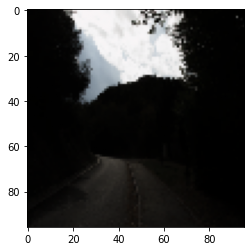

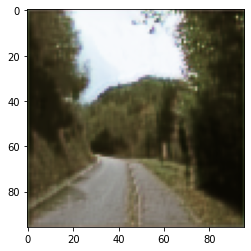

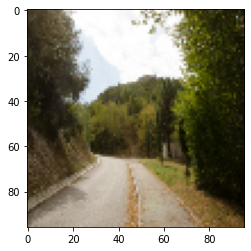

In [31]:
high_light(1443)

In [8]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import keras

In [9]:
model=load_model('model_improved.h5')

In [10]:
model